# Generate the figures

## Imports

In [84]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pickle
import seaborn as sns
import os
import pandas as pd
import muon as mu
import scanpy as sc
import mofax
import anndata as ad

## Load the data

In [85]:
# Define the data and figure folder.
data_folder = "/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/data/"
w_folder = "/users/csb/huizing/Documents/PhD/Code/Mowgli/local_analysis/from_jz/w/"
h_folder = "/users/csb/huizing/Documents/PhD/Code/Mowgli/local_analysis/from_jz/h/"

In [86]:
mdata = mu.read_h5mu(data_folder + "TEA/tea_preprocessed.h5mu.gz")

In [87]:
mdata.obsm["X_mowgli"] = np.load(
    w_folder + "tea_mowgli_cosine_50_0_05_rna_0_01_atac_0_1_adt_0_01_0_001.npy",
    allow_pickle=True,
).item()["W"]
mdata.uns = {}

## Plot the embedding

In [88]:
joint_embedding = ad.AnnData(mdata.obsm["X_mowgli"], obs=mdata.obs)

In [89]:
sc.pp.neighbors(joint_embedding, n_neighbors=20)
sc.tl.umap(joint_embedding)

In [90]:
sc.tl.leiden(joint_embedding, resolution=.5)

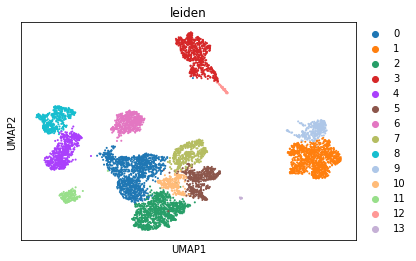

In [91]:
sc.pl.umap(joint_embedding, color="leiden")

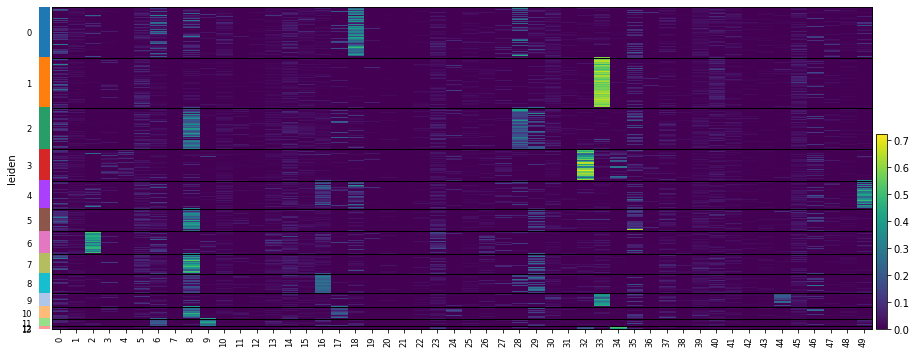

In [92]:
sc.pl.heatmap(joint_embedding, var_names=joint_embedding.var_names, groupby="leiden")

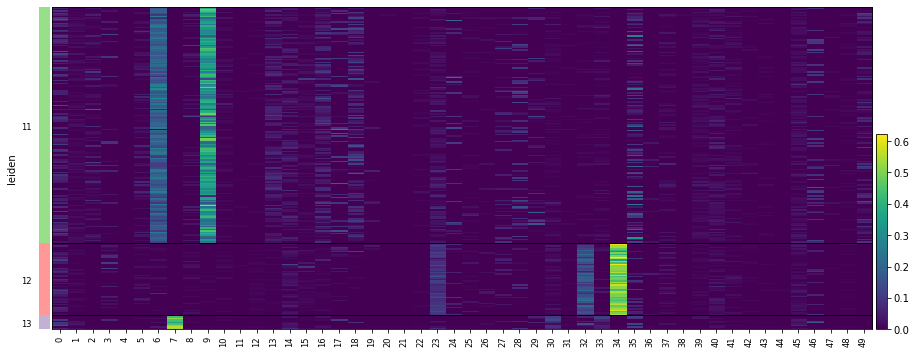

In [93]:
sc.pl.heatmap(joint_embedding[joint_embedding.obs["leiden"].astype(int) > 10], var_names=joint_embedding.var_names, groupby="leiden")

In [94]:
joint_embedding.obs[mdata["adt"].var_names] = mdata["adt"].X

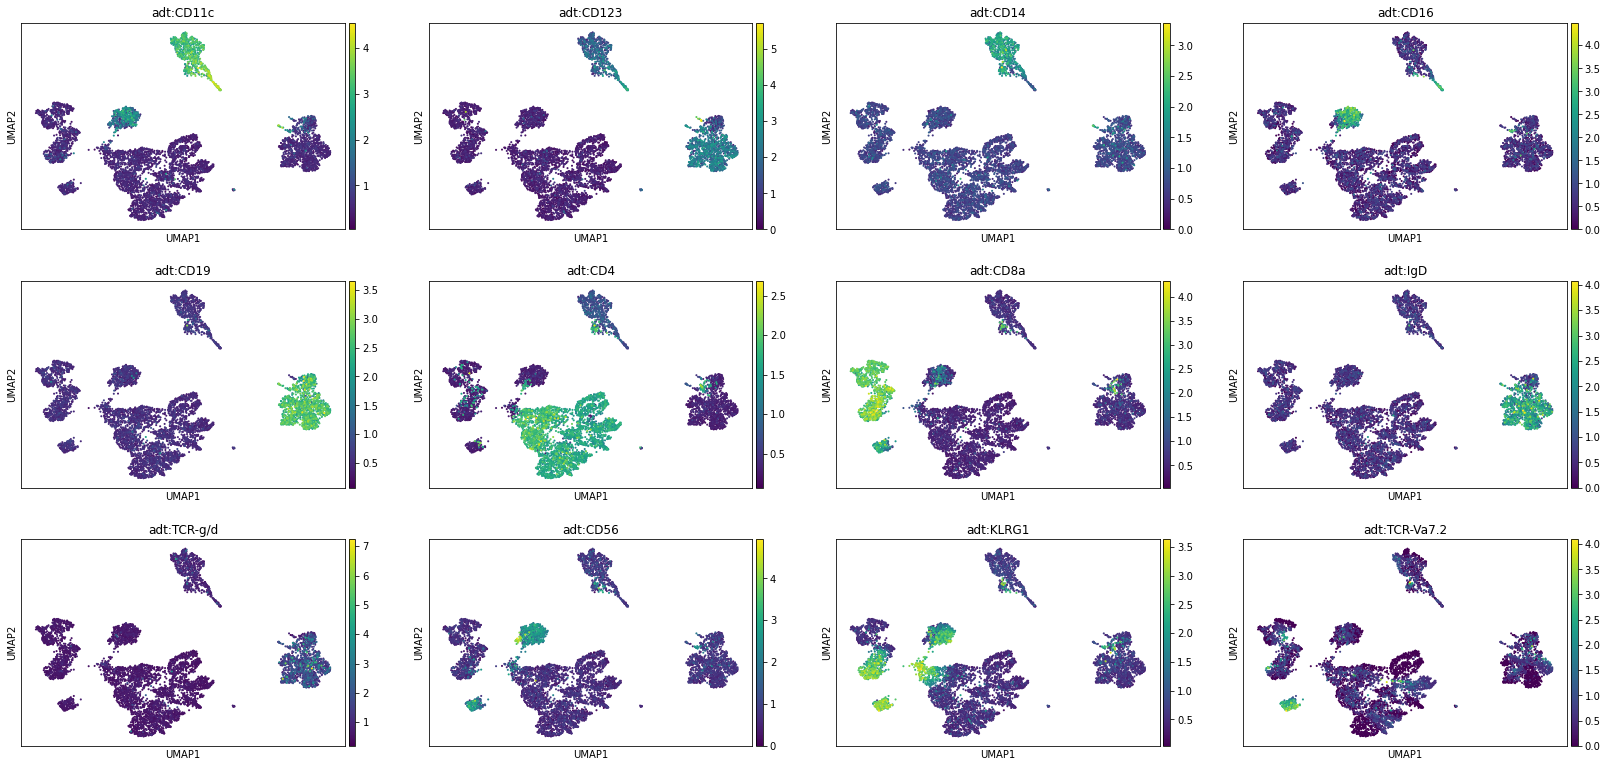

In [95]:
sc.pl.umap(
    joint_embedding,
    color=[
        "adt:CD11c",
        "adt:CD123",
        "adt:CD14",
        "adt:CD16",
        "adt:CD19",
        "adt:CD4",
        "adt:CD8a",
        "adt:IgD",
        "adt:TCR-g/d",
        "adt:CD56",
        "adt:KLRG1",
        "adt:TCR-Va7.2",
    ],
)


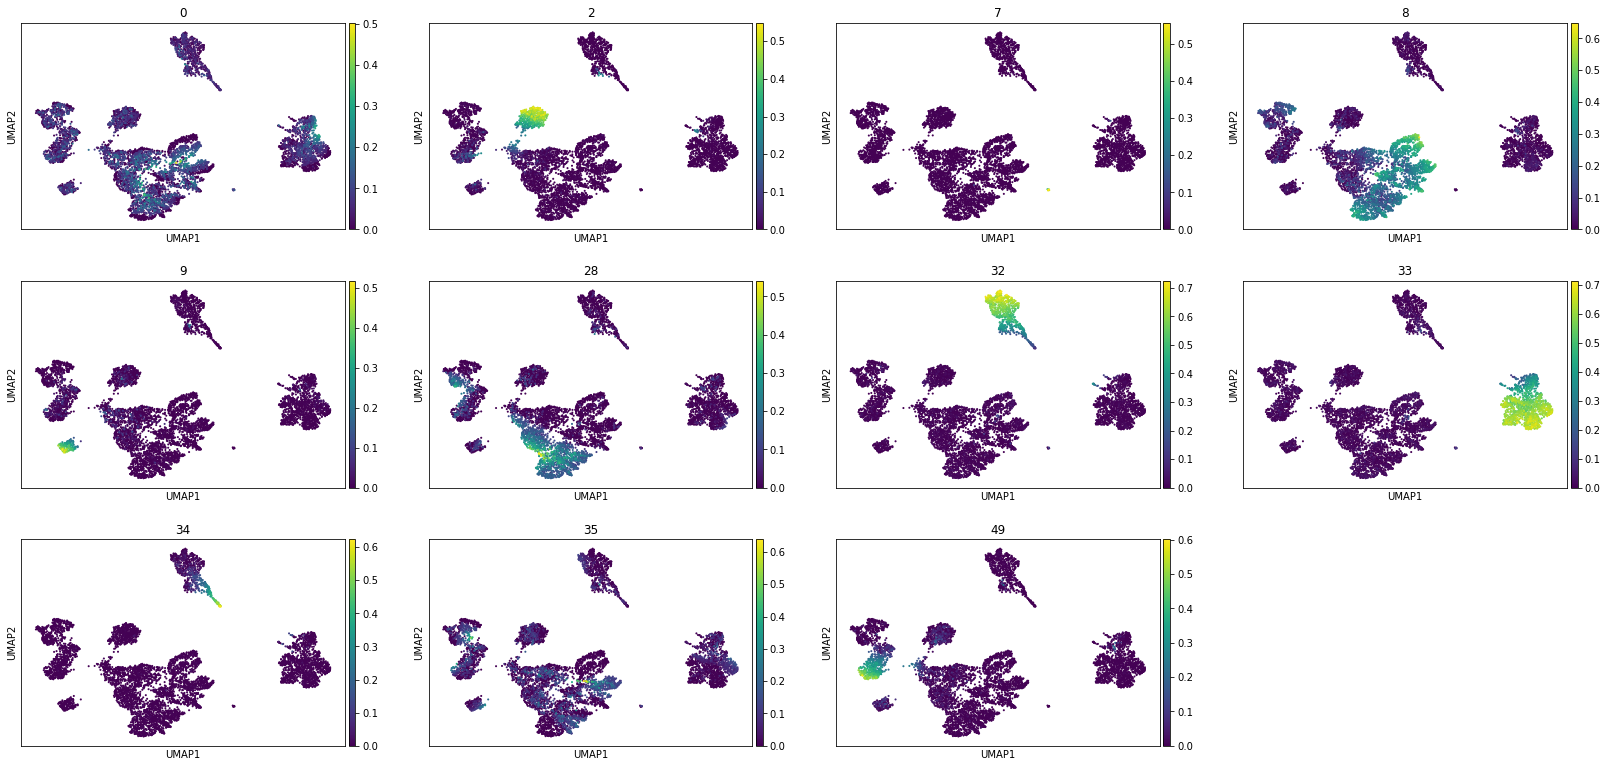

In [96]:
sc.pl.umap(
    joint_embedding,
    color=joint_embedding.var_names[joint_embedding.X.max(0) > .5]
)

## Plot dictionary

In [97]:
H = np.load(
    h_folder + "tea_mowgli_cosine_50_0_05_rna_0_01_atac_0_1_adt_0_01_0_001.npy",
    allow_pickle=True,
).item()

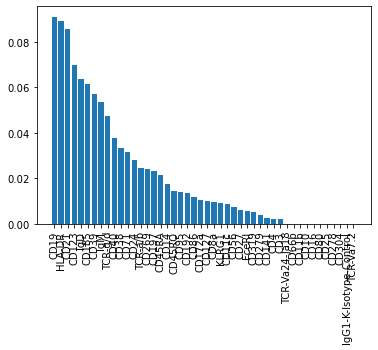

Top 3 proteins CD19, HLA-DR, CD21


In [98]:
idx = H["H_adt"][:, 33].argsort()[::-1]
plt.bar(mdata["adt"].var_names.str.replace("adt:", "")[idx], H["H_adt"][idx, 33])
plt.xticks(rotation=90)
plt.show()
print("Top 3 proteins", ", ".join(mdata["adt"].var_names.str.replace("adt:", "")[idx[:3]]))

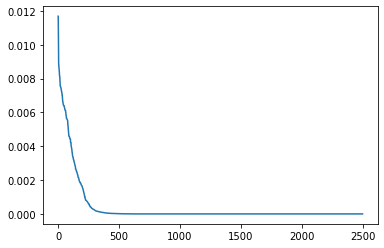

Top 20 genes AFF3, BANK1, LYN, AUTS2, ARHGAP24, ADAM28, SIPA1L1, TRIO, COL19A1, GNG7, CDK14, CD74, RALGPS2, EIF2AK3, EBF1, MGAT5, LARGE1, UBE2E2, CD83, STRBP


In [99]:
idx = H["H_rna"][:, 33].argsort()[::-1]
plt.plot(H["H_rna"][idx, 33])
plt.show()
print("Top 20 genes", ", ".join(mdata["rna"].var_names.str.replace("rna:", "")[idx[:20]]))

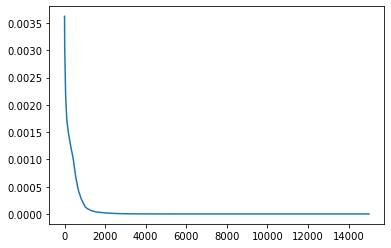

In [100]:
idx = H["H_atac"][:, 33].argsort()[::-1]
plt.plot(H["H_atac"][idx, 33])
plt.show()

## Enrich

In [101]:
import gget

In [102]:
def enrich(dim: int, database: str):
    idx = H["H_rna"][:, dim].argsort()[::-1]
    enr = gget.enrichr(mdata["rna"].var_names.str.replace("rna:", "")[idx[:100]], database)
    enr["min_log_adj_p_val"] = -np.log10(enr["adj_p_val"])
    sns.barplot(data=enr.head(), x='min_log_adj_p_val', y='path_name')
    plt.show()

Fri Aug 26 09:52:30 2022 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Fri Aug 26 09:52:30 2022 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021.


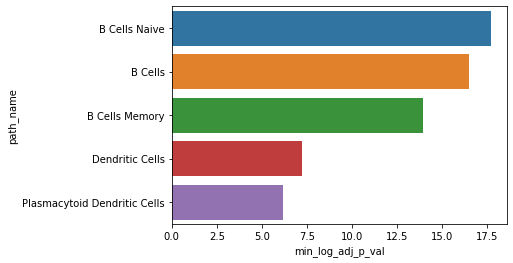

Fri Aug 26 09:52:31 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Fri Aug 26 09:52:31 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


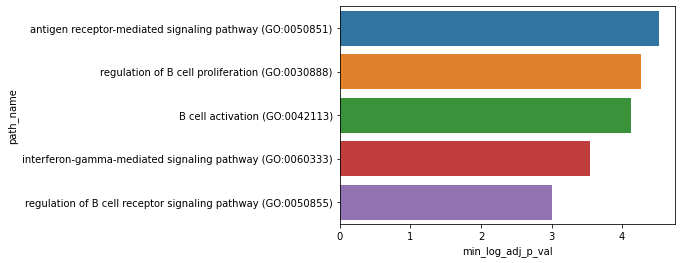

In [103]:
enrich(33, "celltypes")
enrich(33, "ontology")

Fri Aug 26 09:52:33 2022 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Fri Aug 26 09:52:33 2022 INFO Performing Enichr analysis using database PanglaoDB_Augmented_2021.


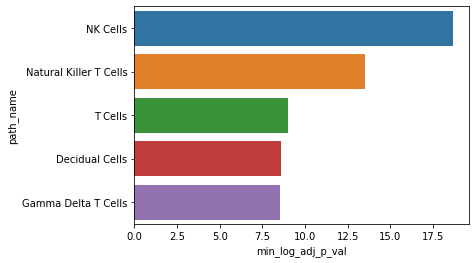

Fri Aug 26 09:52:34 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Fri Aug 26 09:52:34 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


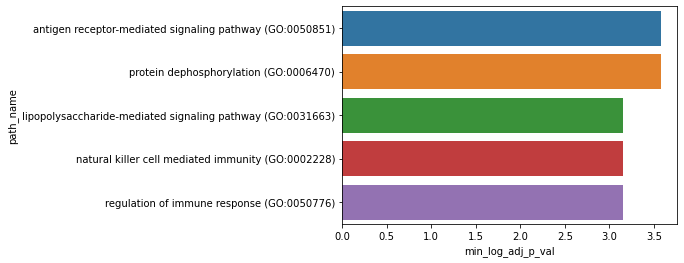

In [104]:
enrich(2, "celltypes")
enrich(2, "ontology")

## Motifs

In [105]:
# rescaled_H = H["H_atac"] / H["H_atac"].sum(1, keepdims=True)
for dim in range(50):
    mdata["atac"].var["top_in_dim_" + str(dim)] = False
    idx = H["H_atac"][:, dim].argsort()[::-1][:50]
    mdata["atac"].var.loc[mdata["atac"].var_names[idx], "top_in_dim_" + str(dim)] = True

In [106]:
mdata["atac"].var.to_csv('/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/top_var.csv')

In [107]:
# Run R

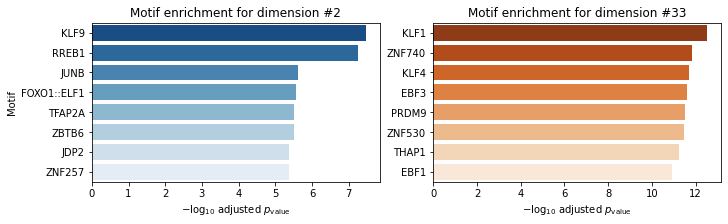

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

motifs = pd.read_csv(
    "/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/motifs/motifs_2.csv",
    index_col=0,
)
motifs = motifs[motifs["motif"].str.startswith("MA")]
motifs["minlogp.adjust"] = -np.log10(motifs["p.adjust"])
sns.barplot(
    data=motifs[:8],
    x="minlogp.adjust",
    y="motif.name",
    ax=axes[0],
    palette="Blues_r",
)
axes[0].set_title("Motif enrichment for dimension #2")
axes[0].set_xlabel(r"$-\log_{10}~\mathrm{adjusted}~p_{\mathrm{value}}$")
axes[0].set_ylabel("Motif")

motifs = pd.read_csv(
    "/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/motifs/motifs_33.csv",
    index_col=0,
)
motifs = motifs[motifs["motif"].str.startswith("MA")]
motifs["minlogp.adjust"] = -np.log10(motifs["p.adjust"])
sns.barplot(
    data=motifs[:8],
    x="minlogp.adjust",
    y="motif.name",
    ax=axes[1],
    palette="Oranges_r",
)
axes[1].set_title("Motif enrichment for dimension #33")
axes[1].set_xlabel(r"$-\log_{10}~\mathrm{adjusted}~p_{\mathrm{value}}$")
axes[1].set_ylabel(None)

plt.show()
